# Tutorial 0: The Core of pykal_core
## Overview

This tutorial will walk you through the genesis and structure of the pykal_core library. Upon finishing this tutorial, you will be able to model simple systems using the pykal_core library, as shown in tutorial 1.

The motivation behind the module and class architecture in this package is discussed, as well as the motivation behind the creation of this package itself (the theory being that it is easier to use a tool if you known why it is designed the way it is).

This is the only tutorial in which the pronoun "I" is used instead of the more acedemic "we", as I found it strange to hide behind plurality when discussing design decisions whose benefits and shortcomings are ultimately my fault.

## Background

### Why did I make pykal_core?

Because I am not an engineer. My background is in physics and mathematics; I hold a bachelors in the former and a masters in the latter. I wasn't drawn to robotics because of the money, or the status, or the hordes of women who would fall at my feet. Rather, I was drawn to the field by its progenitor: control theory. 

Control theory is at once elegant and powerful, and if control theory is fundamental in most fields of engineering, then it is the field entire in robotics. I loved reading about novel methods of estimating states in nonlinear systems (using Lie-theoretic methods on manifols), or methods of controlling drones using differential geometry (the same matehmaticl framwwork used in general relativity), but I found, to my dismay, that there was no way to actually implement these ideas easily.

Every journey from brain to robot became a tangled mess of code and libraries, cobbled together with existing tools never designed for the flexiblity of which they were asked. This is a long and frustrating journey, and whenever a researcher wants to move their ideas from 'in vivo' to 'in silica', they are forced to make it again.

Enter the pykal framework. Like the child of a couple trying to save their marriage, the framework was born out of frustration, and the unhappy coupling it sought to solve was that of theoretical control systems and practical robotics. 


### The Feedback System

A basic feedback system is shown below in block-diagram format. The cruise control in your car and the AC in your home are just two examples.

   <div style="display: flex; align-items: center; justify-content: space-between; gap: 2em; margin-top: 1em; margin-bottom: 1em;">
     <img src="../../_static/system_input_observer_controller_block_diagram.svg" alt="System Observer Controller Block Diagram" style="width: 50%;">
   </div>

There are three objects in the block diagram which fall under the "control system" category:
- Dynamical System (or plant): This is the actual dynamical system we are interested in controlling. This would be the car for your cruise control and the home for your AC.
- Observer (or estimator): This is a function which returns the estimated state that we are interested in controlling. This would be the speed of your car or the temperature of your home. 
- Controller: This is a function which recieves as input some transformation (often the difference) of the setpoint r and the state feedback xhat and computes the corresponding output to the dynamical system such that the dynamical system is "controlled" to the desired set point. The controller might pump the brakes of your car or turn the AC on for your home. 

There are two objects in the block diagram which fall under the "function block" category:
- Signal generator: As the name suggests, this is a function that generates a signal. In the examples above, this would generate the setpoint r for the systems.
- t (signal transform): this is a function that takes as inputs two signals and outputs a signal. In the examples above, this is teh difference e.g. t(r,xhat) = r - xhat 

### The Feedback System as classes and modules
The pykal_core class and module structure is designed to mimic this distinction.

The text in red shows either directories or files (python modules). 

The blocks in blue are classes which are user-facing; the blocks in white are "utility classes" which are designed for use by the blue blocks (although the user can access these too, if needed). 

The arrows show composition, not inheritance (there is no inheritance in this package). 

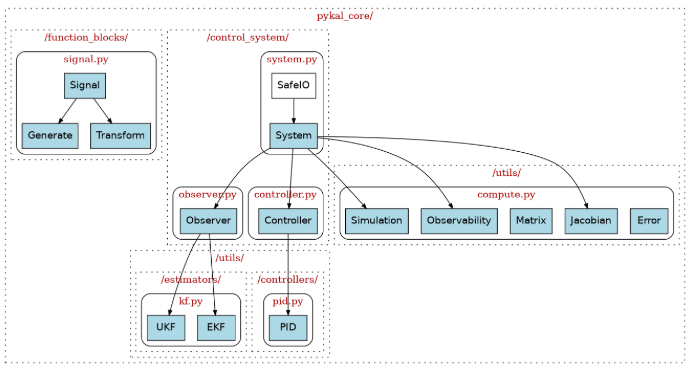

I will explain the motivation behind each module, how its classes relate to other classes in the framework, and example usage of relavant classes. It is recommended that each module is explored in the following order:
con



## control_system/
The control system directory holds the modules system.py, observer.py, and controller.py, which relate to their respective objects in the feedback diagram. 

### system.py

#### System
Recall that the state-space model of a continuous-time dynamical system is given by:

$$
\begin{aligned}
\dot{x} &= f(x, u, t) + w(t) \\
y &= h(x, u, t) + r(t)
\end{aligned}
$$

Where:

- $x \in \mathbb{R}^{n}$ is the **state vector**
- $u \in \mathbb{R}^{p}$ is the **input vector**
- $t \in \mathbb{R}^{+}$ is **time**
- $w(t) \in \mathbb{R}^{n}$ is **process noise**, distributed as $w \sim \mathcal{N}(0, Q(t))$, where $Q(t) \in \mathbb{R}^{n \times n}$ is the **process noise covariance matrix**

Similarly:

- $y \in \mathbb{R}^{m}$ is the **measurement vector**
- $r(t) \in \mathbb{R}^{m}$ is **measurement noise**, distributed as $r \sim \mathcal{N}(0, R(t))$, where $R(t) \in \mathbb{R}^{m \times m}$ is the **measurement noise covariance matrix**

Note that there are four functions that define the behavior of the system: $f$, $h$, $w$, and $r$.

In [1]:
from pykal_core.control_system.system import System

sys = System(state_names=["x0","x1"]) # state names are the only required argument for the constructor

for key, value in sys.__dict__.items():
    print(f"{key}: {value}")

safeio: <pykal_core.control_system.system.System.SafeIO object at 0x7b5ac8953710>
_state_names: ['x0', 'x1']
_measurement_names: ['x0_meas', 'x1_meas']
_system_type: cti
_f: <function System.f_zero at 0x7b5ab1d316c0>
_h: <function System.h_identity at 0x7b5ab1d32700>
_Q: <function System.make_Q.<locals>.Q at 0x7b5ac8961120>
_R: <function System.make_R.<locals>.R at 0x7b5ac941a020>


Note that the `sys` object is initialized with several default attributes if they are not passed to the constructor. The `System.safeio` object is an instance of utility subclass which is composed with all instances of `System`; it will be discussed in the next section.

`sys._measurement_names` are the default measurement names (assumed to be full-state measurements) 

In [2]:
sys.measurement_names

['x0_meas', 'x1_meas']

`sys.system_type` is the time structure of the dynamical system (default is "cti", or "continuous time-invariant")

In [3]:
sys.system_types # all available system time structures for sys

{'cti', 'ctv', 'dti', 'dtv'}

`System.f_zero` is the function $f(x,u,t) = 0$ ie a dynamical system that does not change over time


In [4]:
import numpy as np
xk = np.array([[1.0], [0.0]])
sys.f(xk)

array([[0.],
       [0.]])

`System.h_identity` is the function $h(x,u,t)=x$ ie the measurements are simply the state.

In [5]:
xk = np.array([[1.0], [0.0]])
sys.h(xk)

array([[1.],
       [0.]])


`System.make_Q.<locals>.Q` is the process noise covariance $Q$ created by a factory function `System.make_Q`. The default $Q$ returns an identity matrix with noise $0.01$ on the diagonals.


In [6]:
sys.Q()

array([[0.01, 0.  ],
       [0.  , 0.01]])

`System.make_R.<locals>.Q` is the measurement noise covariance $R$ created by a factory function `System.make_R`. The default $R$ returns an identity matrix with noise $0.01$ on the diagonals.

In [7]:
sys.R()

array([[0.01, 0.  ],
       [0.  , 0.01]])

As an example, consider the pendulum (pulled from tutorial 1) below:

In [8]:
import numpy as np
from numpy.typing import NDArray

#### SafeIO

It seems that we can easily define system objects, as the previous example showed. But now we find ourselves in a subtle Pythonic pickle: what if our state dynamics only depended upon x, that is, ``f(x)`` instead of ``f(x,u,t)``? Any other classes or modules that compose System objects would expect ``System.f`` to have the arguments x, u, and t, in that order. We could simply define all functions like this, and choose not to use arguments that are not needed, but this breaks compatibability with existing tools. For instance, SciPy expects its functions in ``f(t, x)`` format, while JAX prefers ``f(x, u, t)`` or ``f(x, t)``. 

Furthermore, the flexibility of Python functions can be a double-edged sword. While it enables rapid prototyping, it also allows functions with inconsistent signatures, missing type annotations, ambiguous return types, or dynamic behavior that can silently break downstream logic.

Consider the pendulum example with C:

.. code-block:: c

   // C: fixed signature, explicit memory, compiler-enforced interface
   void dynamics(const double *x, const double *u, double t, double *x_dot_out) {
       x_dot_out[0] = x[1];
       x_dot_out[1] = -x[0];
   }

In C, functions must declare exactly what inputs they need and what outputs they produce.
Return types and pointer sizes are enforced at compile time, and passing the wrong number
of arguments or mismatched types raises immediate, traceable errors.

In Python, however, the same function might look like:

.. code-block:: python

   def f(x, u, t):
       return np.vstack([x[1], -x[0]])

We are at the mercy of runtime users to pass in the correct values, and to have the output be correct and of the correct shape. These kinds of mismatches are notoriously difficult to trace—especially when using external libraries like TensorFlow, PyTorch, or JAX that wrap or recompile functions dynamically.

Without a consistent interface, chaos creeps in. 

Hence, a utility class was created: ``SafeIO``.

This class validates user-defined functions at the time of registration (not just runtime). It also injects only necessary arguments and any keyword argumetns as needed, and enforces that all returned values are properly typed and shaped. It does this with the smart call function.

In [9]:
for key, value in sys.safeio.__dict__.items():
    print(f"{key}: {value}")

parent: <pykal_core.control_system.system.System object at 0x7b5ac8998920>
_aliases_for_x: ['x', 'x_k', 'xk', 'state']
_aliases_for_u: ['u', 'u_k', 'uk', 'input']
_aliases_for_t: ['t', 't_k', 'tk', 'time', 'tau']
smart_call: <bound method System.SafeIO.smart_call of <pykal_core.control_system.system.System.SafeIO object at 0x7b5ac8953710>>


In [10]:
# 1. returns_scalar – should raise TypeError
try:
    def returns_scalar(x: NDArray) -> float:
        return 3.14

    x = np.array([[1.0]])
    sys.safeio.smart_call(returns_scalar, x=x)
except TypeError as e:
    print(f"TypeError: {e}")

TypeError: In `returns_scalar`, return type must be NDArray[...] or a tuple of NDArrays, but got <class 'float'>


In [11]:
# 2. wrong_output_shape – should raise ValueError
try:
    def wrong_output_shape(x: NDArray) -> NDArray:
        return np.zeros((1, 1))

    sys.safeio.smart_call(wrong_output_shape, x=np.zeros((2, 1)), expected_shape=(2, 1))
except ValueError as e:
    print(f"ValueError: {e}")

ValueError: Output shape mismatch. Expected (2, 1), got (1, 1)


In [12]:
# 3. no_arguments
def no_arguments() -> NDArray:
    return np.ones((2, 1))

print(sys.safeio.smart_call(no_arguments))

[[1.]
 [1.]]


In [13]:
# 4. state_only
def state_only(x: NDArray) -> NDArray:
    return x + 1


x = np.array([[1.0], [2.0]])
print(sys.safeio.smart_call(state_only, x=x))

[[2.]
 [3.]]


In [14]:
# 5. input_only
def input_only(u: NDArray) -> NDArray:
    return u * 2

u = np.array([[0.5], [1.0]])
print(sys.safeio.smart_call(input_only, u=u))

[[1.]
 [2.]]


In [15]:
# 6. time_only
def time_only(t: float) -> NDArray:
    return np.array([[t], [t]])

print(sys.safeio.smart_call(time_only, t=3.0))

[[3.]
 [3.]]


In [16]:
# 7. state_input
def state_input(x: NDArray, u: NDArray) -> NDArray:
    return x + u

print(sys.safeio.smart_call(state_input, x=x, u=u))

[[1.5]
 [3. ]]


In [17]:
# 8. state_time
def state_time(x: NDArray, t: float) -> NDArray:
    return x * t

print(sys.safeio.smart_call(state_time, x=x, t=2.0))

[[2.]
 [4.]]


In [18]:
# 9. input_time
def input_time(u: NDArray, t: float) -> NDArray:
    return u + t

print(sys.safeio.smart_call(input_time, u=u, t=1.0))

[[1.5]
 [2. ]]


In [19]:
# 10. all_arguments
def all_arguments(x: NDArray, u: NDArray, t: float) -> NDArray:
    return x + u + t

print(sys.safeio.smart_call(all_arguments, x=x, u=u, t=1.0))

[[2.5]
 [4. ]]


In [20]:
# 11. reordered_arguments
def reordered_arguments(t: float, u: NDArray, x: NDArray) -> NDArray:
    return x + u + t

print(sys.safeio.smart_call(reordered_arguments, x=x, u=u, t=1.0))

[[2.5]
 [4. ]]


In [21]:
# 12. aliased_names
def aliased_names(state: NDArray, input: NDArray, time: float) -> NDArray:
    return state + input + time

print(sys.safeio.smart_call(aliased_names, x=x, u=u, t=1.0))

[[2.5]
 [4. ]]


In [22]:
# 13. with extra keyword arguments (note that u and t are not used either)
def just_x(x: NDArray) -> NDArray:
    return x * 2

print(sys.safeio.smart_call(just_x, x=x, u=u, t=2.0, extra_arg=3))

[[2.]
 [4.]]


In [23]:
def just_x_and_extra_kwarg(xk:NDArray,extra_arg:float) -> NDArray:
    return xk * extra_arg

print(sys.safeio.smart_call(just_x_and_extra_kwarg, x=x, u=u, t=2.0, extra_arg=3))

[[3.]
 [6.]]


### observer.py


#### Observer

Recall that the observer of a dynamical system is given by:

$$
\hat{x} = L(u,y)
$$

Where:
- $\hat{x} \in \mathbb{R}^{n}$ is the **estimated state vector**
- $y \in \mathbb{R}^{m}$ is the **measurement vector**
- $u \in \mathbb{R}^{p}$ is the **input vector**

Note that there is only one function that define the behavior of the observer: $L$. But this is high-level, often complexity comes in the functions composing L. For example, the kalman filter only requires y and u as active inputs, but is initialized with ..., and internal stuff.

   <div style="display: flex; align-items: center; justify-content: space-between; gap: 2em; margin-top: 1em; margin-bottom: 1em;">
     <img src="../../_static/observer_kf.svg" alt="Observer kf  Diagram" style="width: 50%;">
   </div>

In [24]:
from pykal_core.control_system.observer import Observer
obs = Observer(sys)

In [25]:
for key, value in obs.__dict__.items():
    print(f"{key}: {value}")

sys: <pykal_core.control_system.system.System object at 0x7b5ac8998920>
L: None


In [26]:
from pykal_core.utils.estimators import kf
obs.L = kf.make_L(obs,kf.predict_EKF,kf.update_EKF)

In [28]:
obs.L.__name__

'kf'

In [30]:
for key, value in obs.__dict__.items():
    print(f"{key}: {value}")

sys: <pykal_core.control_system.system.System object at 0x7b5ac8998920>
L: <function make_L.<locals>.kf at 0x7b5ab1d605e0>
P_est_hist: []
x_est_hist: []
clear_P_est_and_x_est_history: <function make_L.<locals>.clear_P_est_and_x_est_history at 0x7b5ac8b072e0>


If we do onw with beta, we would see beta as well (sweet!) Also, note to self, I need to do the for loop simulation with initializations availbable before hand. That would be most simple and translate well to ROS, I think.

How do i tell my parents im secretly gay?

For all estimators and how to use hhem, see the API reference here:

## function_blocks/